In [1]:
import numpy as np
from quantecon.optimize import brent_max, brentq
from interpolation import interp
from numba import njit, float64, jitclass
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import MarkovChain
import quantecon as qe 
from HARK.utilities import getLorenzShares, getPercentiles
from scipy import interpolate

import pandas as pd 
import seaborn as sns

In [2]:
ifp_data = [
    ('γ', float64),              # utility parameter
    ('β', float64),              # discount factor
    ('R',float64),               # interest rate factor 
    ('p_vec',float64[:]),        # price vector
    ('eps', float64),            # EOS 
    ('phi', float64),            # share of sector 1 consumption
    ('P', float64[:, :]),        # transition probs for z_t
    ('z_val', float64[:]),       # values of z 
    ('a_s', float64),            # scale parameter for S_t
    ('b_s', float64),            # additive parameter for S_t
    ('a_y', float64),            # scale parameter for Y_t
    ('b_y', float64),            # additive parameter for Y_t
    ('s_grid', float64[:]),      # Grid over savings
    ('η_draws', float64[:]),     # Draws of innovation η for MC
    ('ζ_draws', float64[:])      # Draws of innovation ζ for MC
]

In [23]:
@njit
def p_composite(p_vec,
                eps,
                phi,
                S):
    ## composite price index 
    p_idx = ((S*phi)**eps*p_vec[0]**(1-eps)+(1-phi)**eps*p_vec[1]**(1-eps))**(1/(1-eps))
    return p_idx

@njit
def MU_multiply(c,
                p_vec,
                eps,
                phi,
                S,
                γ):
    p_idx = p_composite(p_vec,
                       eps,
                       phi,
                       S)
    term = (S*phi)**eps*(p_vec[0]/p_idx)**(1-eps)+(1-phi)**eps*(p_vec[1]/p_idx)**(1-eps)
    to_multiply = (term)**(eps*(1-γ)/(eps-1))
    return c**(-1/γ)/to_multiply


def u_prime(model,
            c,
            S):
    p_vec = model.p_vec
    eps,phi,γ = model.eps,model.phi,model.γ
    
    ## composite price index 
    to_multiply = MU_multiply(c,
                              p_vec,
                              eps,
                              phi,
                              S,
                              γ)
    return to_multiply*c**(-γ)
    

def u_prime_inv(model, 
                c, 
                S):
        ##  s is the taste shock to the sector 1 
        p_vec = model.p_vec
        phi, eps = model.phi, model.eps
        γ = model.γ
        ## composite price index 
        to_multiply = MU_multiply(c,
                                  p_vec,
                                  eps,
                                  phi,
                                  S,
                                  γ)
        return c**(-1/γ)/to_multiply

In [24]:
@jitclass(ifp_data)
class IFCAP:  ## income fluctuation and consumption allocation problem 
    """
    A class that stores primitives for the income fluctuation and 2-sector consumption
    allocation problem.
    """

    def __init__(self,
                 γ = 1.5,
                 β = 0.96,
                 P = np.array([(0.9, 0.1),
                             (0.1, 0.9)]),
                 z_val = np.array([1.0,2.0]), 
                 a_s = 0.1,     ## size of the taste shock  
                 b_s = - 0.2,   ## coefficient of pandemic state on taste 
                 a_y = 0.3,     ## size of income risks
                 b_y = - 0.3,   ## coefficient of pandemic state on income 
                 R = 1.03,
                 p_vec = np.array([0.8,1]), ## price vector of two goods
                 eps = 0.75,    ## EOS between two goods
                 phi = 0.5,     ## steady state share of the first good
                 shock_draw_size = 50,
                 grid_max = 5,
                 grid_size = 100,
                 seed = 1234):

        np.random.seed(seed)  # arbitrary seed

        self.γ, self.β = γ, β
        
        self.R = R 
        self.a_s, self.b_s, self.a_y, self.b_y = a_s, b_s, a_y, b_y
        
        self.η_draws = np.random.randn(shock_draw_size)
        self.ζ_draws = np.random.randn(shock_draw_size)
        self.s_grid = np.linspace(0, grid_max, grid_size)
        
        self.P, self.z_val = P, z_val

        # Test stability assuming {R_t} is IID and adopts the lognormal
        # specification given below.  The test is then β E R_t < 1.
        #ER = np.exp(b_r + a_r**2 / 2)
        assert β * R < 1, "Stability condition failed."

    # Marginal utility
    def u_prime(self, c, S):   ## this is the MU from indirect utility function that depends on taste shock 
        
        ##  S is the taste shock to the sector 1 
        
        p_vec = self.p_vec
        phi, eps = self.phi, self.eps
        
        γ = self.γ
        ## composite price index 
        to_multiply = MU_multiply(c,
                                  p_vec,
                                  eps,
                                  phi,
                                  S,
                                  γ)
        return to_multiply*c**(-γ) 

    # Inverse of marginal utility
    def u_prime_inv(self, c, S):
        ##  s is the taste shock to the sector 1 
        p_vec = self.p_vec
        phi, eps = self.phi, self.eps
        γ = self.γ
        ## composite price index 
        to_multiply = MU_multiply(c,
                                  p_vec,
                                  eps,
                                  phi,
                                  S,
                                  γ)
        return c**(-1/γ)/to_multiply

In [25]:
## an instance 

ifp = IFCAP()

## feed a markov tanchened from ar1

ρ, σ = (0.978,0.18)
mc = qe.markov.tauchen(ρ,σ,n=7) 
constant = np.exp(0.13)
ifp.z_val, ifp.P = mc.state_values+constant, mc.P

In [39]:
u_primes = u_prime(ifp,
                    1,
                    np.linspace(0.01,2))

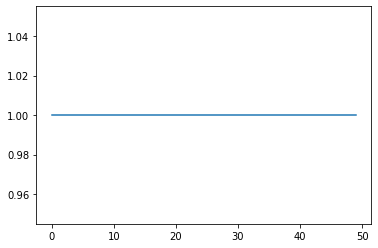

In [40]:
plt.plot(u_primes)

In [37]:
u_primes_inv = u_prime_inv(ifp,
                    1,
                    np.linspace(0.01,2))

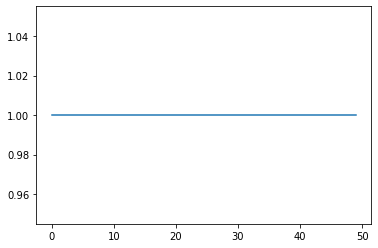

In [38]:
plt.plot(u_primes_inv)